In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import interpolate
from scipy.optimize import fsolve
import torch
import torch.nn as nn
torch.manual_seed(0)
np.random.seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

import sys
from pathlib import Path

Path("./Paper Figures/").mkdir(parents=True, exist_ok=True)
Path("./Paper Data/").mkdir(parents=True, exist_ok=True)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

/home/magister-nihili/miniconda3/envs/NEIM2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PODNN_Net(nn.Module):
    def __init__(self, in_size, out_size, num_hidden=1, width=50):
        super(PODNN_Net, self).__init__()
        self.width = width
        self.layers = [nn.Linear(in_size, width)]
        for i in range(num_hidden-1):
            self.layers.append(nn.Linear(width, width))
        self.layers.append(nn.Linear(width, out_size))
        self.layers = nn.ModuleList(self.layers)
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = torch.tanh(x)
        x = self.layers[-1](x)
        return x

In [3]:
def DEIM(U):
    """
    Compute DEIM interpolation indices given
    U = {u_i}_i matrix with linearly independent columns.
    """
    U = np.copy(U)
    selected_indices = []
    
    for i in range(U.shape[1]):
        idx = np.argmax(np.abs(U[:, i]))
        selected_indices.append(idx)
        U = U - 1/U[idx, i] * U[:, [i]] @ U[[idx], :]
    
    return selected_indices

In [4]:
def weighted_mse_loss(input, target, weight):
    return (weight * (input - target) ** 2).mean()

class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_size, 50)
        self.fc2 = nn.Linear(50, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x

def NEIM(ro_sols, f_NEIM, mu, V, max_modes=10, train_loop_iterations=10000):
    """
    Compute NEIM for solution
    independent nonlinearities.
    """
    NUM_PARAMS = f_NEIM.shape[0]
    RO_DIM = ro_sols.shape[1]
    
    #WEIGHTS = np.array([[(abs(i - j) <= 1)/(1+10000*abs(i-j)**2) for j in range(mu.shape[0])] for i in range(mu.shape[0])])
    WEIGHTS = np.ones((mu.shape[0], mu.shape[0]))
    #WEIGHTS = np.array([[np.exp(-100*np.abs(mu[i] - mu[j])) for j in range(mu.shape[0])] for i in range(mu.shape[0])])
    #WEIGHTS = np.array([[(i == j)*1.0 for j in range(mu.shape[0])] for i in range(mu.shape[0])])
    
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    errors = np.array([np.sum(f_NEIM[i, i]**2) for i in range(NUM_PARAMS)])
    idx = np.argmax(errors)
    selected_indices.append(idx)
    print(idx, "Max Error:", errors[idx], "Mean Error:", np.mean(errors))
    
    Network_mu_1 = Net(RO_DIM, RO_DIM)
    mse_weights = torch.tensor(WEIGHTS[idx].reshape(-1, 1))
    optimizer = torch.optim.Adam(Network_mu_1.parameters(), lr=0.001)    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)
    
    x_data = torch.tensor(ro_sols, dtype=torch.double)
    y_data = torch.tensor(np.array([f_NEIM[idx, j]/np.linalg.norm(f_NEIM[idx, j]) for j in range(f_NEIM.shape[1])]))
    
    for epoch in range(train_loop_iterations):
        optimizer.zero_grad()
        output = Network_mu_1(x_data)
        loss = weighted_mse_loss(output, y_data, mse_weights)
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
    
    Network_mu_1.eval()
    trained_networks.append(Network_mu_1)
    
    thetas = np.zeros((NUM_PARAMS, 1), dtype=np.double)
    for i in range(NUM_PARAMS):
        numerator = 0
        denominator = 0
        for j in range(NUM_PARAMS):
            if i == j:
                net_u_mu = Network_mu_1(x_data[j].view(1, -1)).detach().numpy().reshape(-1)
                numerator += WEIGHTS[i, j] * np.dot(f_NEIM[i, j], net_u_mu)
                denominator += WEIGHTS[i, j] * np.dot(net_u_mu, net_u_mu)

        theta_1_1_i = numerator / denominator
        thetas[i] = theta_1_1_i    
    
    for iteration in range(max_modes-1):
        # current approximation
        approx = lambda sol, param_idx: sum([
            thetas[param_idx][i] * net(torch.tensor(sol).view(1, -1)).T.detach().numpy().reshape(-1)\
            for i, net in enumerate(trained_networks)
        ])
    
        
        # Compute Errors and Choose New Parameter
        errors = np.array([np.sum((f_NEIM[i, i] - approx(ro_sols[i], i))**2) for i in range(NUM_PARAMS)])
        print("Mean Already Selected Error:", np.mean(errors[np.array(selected_indices)]))
        errors[np.array(selected_indices)] = -1
        mu_2_idx = np.argmax(errors)
        selected_indices.append(mu_2_idx)
        print(mu_2_idx, "Max Error:", errors[mu_2_idx], "Mean Error:", np.mean(errors[errors>=0]))
        
        Network_mu_2 = Net(RO_DIM, RO_DIM)
        mse_weights = torch.tensor(WEIGHTS[mu_2_idx].reshape(-1, 1))
        optimizer = torch.optim.Adam(Network_mu_2.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)


        # need to do Gram-Schmidt on this matrix
        previous_y_data = np.copy(y_data)
        y_data = np.copy(f_NEIM[mu_2_idx])
        
        for net in trained_networks:
            # form matrix of evaluations for this network
            previous_net_matrix = np.zeros((NUM_PARAMS, f_NEIM.shape[2]), dtype=np.double)
            for i in range(NUM_PARAMS):
                previous_net_matrix[i] = net(x_data[i].view(1, -1)).detach().numpy().reshape(-1)
                y_data[i] -= np.dot(y_data[i], previous_net_matrix[i]) * previous_net_matrix[i] / np.linalg.norm(previous_net_matrix[i])**2
        
        for j in range(f_NEIM.shape[1]):
             y_data[j] = y_data[j] / np.linalg.norm(y_data[j])
        
        y_data = torch.tensor(y_data, dtype=torch.double)
        
        for epoch in range(train_loop_iterations):
            optimizer.zero_grad()
            output = Network_mu_2(x_data)
            loss = weighted_mse_loss(output, y_data, mse_weights)
            if epoch % 100 == 0:
                print(epoch, loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

        Network_mu_2.eval()
        trained_networks.append(Network_mu_2)
        
        # 3c. Find theta_1_2(mu), theta_2_2(mu)
        print("\nFinding theta...")
        num_nets = len(trained_networks)
        thetas = np.zeros((NUM_PARAMS, num_nets), dtype=np.double)
        for i in range(NUM_PARAMS):
            LHS = np.zeros((num_nets, num_nets), dtype=np.double)
            RHS = np.zeros((num_nets, 1), dtype=np.double)

            for j in range(NUM_PARAMS):
                if i == j:
                    nets_u_mu = [net(x_data[j].view(1, -1)).detach().numpy().reshape(-1) for net in trained_networks]
                    for k1 in range(num_nets):
                        RHS[k1] += WEIGHTS[i, j] * np.dot(f_NEIM[i, j], nets_u_mu[k1])
                        for k2 in range(num_nets):
                            LHS[k1, k2] += WEIGHTS[i, j] * np.dot(nets_u_mu[k1], nets_u_mu[k2])

            thetas[i] = np.linalg.solve(LHS, RHS).reshape(-1)
        
    def NEIM_approximation(new_mu, new_sol, num_modes=-1):
        if num_modes == -1:
            num_modes = len(trained_networks)
        
        new_sol = torch.tensor(new_sol)
        thetas_ = interpolate.griddata(mu, thetas, new_mu, method='cubic').reshape(-1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas, new_mu, method='nearest').reshape(-1)
        s = 0
        for i, net in enumerate(trained_networks[:num_modes]):
            s += thetas_[i] * net(new_sol.view(1, -1)).view(-1).detach().numpy()
        return s.reshape(-1)
    
    return NEIM_approximation, selected_indices

# Nonlinear parameterized function with spatial points in one dimension
Example from DEIM paper section 3.3.1:

We have a nonlinear parameterized function $s:\Omega\times\mathbb{R}\times\mathcal{P}\to\mathbb{R}$ defined by $$s(x, u;\mu) = (1-\lvert x\rvert)e^{-(1+x)u\mu},$$ where $\Omega = [-1, 1]$ and $\mu\in\mathcal{P} = [1,\pi]$.

Let $\boldsymbol{x} = [x_1,\dots,x_n]^\top\in\mathbb{R}^n$ with $x_i$ equally spaced points in $\Omega$ for $i=1,\dots,n$, with $n=100$. Define $f:\mathcal{P}\to\mathbb{R}^n$ by $$f(\mu) = [s(x_1, u(x_1;\mu);\mu),\dots,s(x_n, u(x_n;\mu);\mu)]^\top\in\mathbb{R}^n$$ for $\mu\in\mathcal{P}$. Here $u(x_i;\mu)$ is the solution of a parameterized PDE with parameter $\mu$ evaluated at $x_i$.

We then use 51 snapshots $f(\mu_j)$ to construct a POD basis $\{u_\ell\}_{\ell=1}^m$, with $\mu_1,\dots,\mu_{51}$ selected as equally spaced points in $[1,\pi]$.

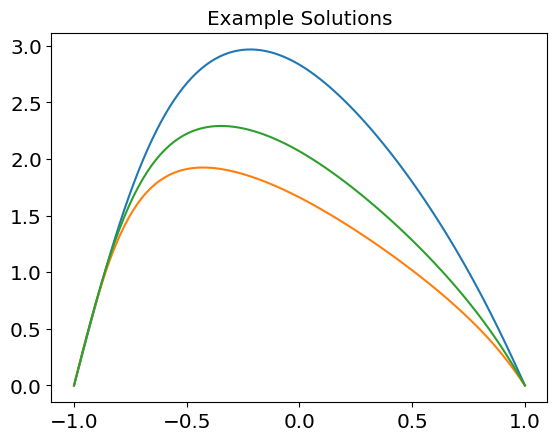

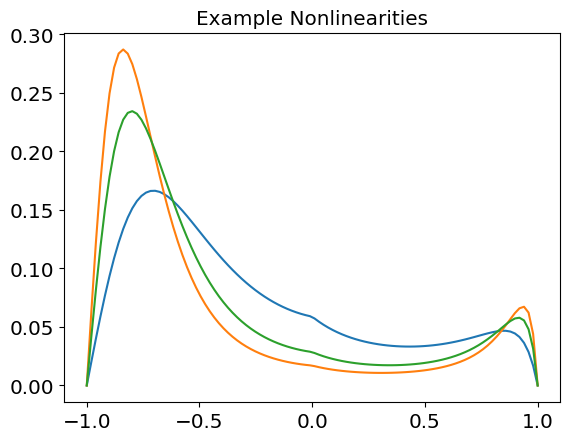

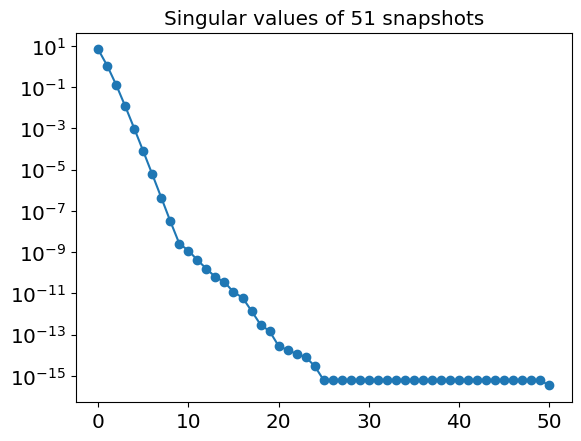

In [5]:
def s(u, x, mu):
    return mu * (1-np.abs(x)) * np.exp(-(1 + x) * u * mu)

def residual(A, u, x, mu):
    u[0] = 0
    u[-1] = 0
    r = (A @ u.reshape(-1, 1) - s(u.reshape(-1, 1), x, mu)).reshape(-1)
    return r

def solution_fn(x, mu):
    # compute full order solutions
    N = x.shape[0]
    A = 2*np.eye(N, dtype=np.double) - np.eye(N, k=1, dtype=np.double) - np.eye(N, k=-1, dtype=np.double)
    A = 30*A
    A[0, :] *= 0
    A[-1, :] *= 0
    A[:, 0] *= 0
    A[:, -1] *= 0
    sols = np.zeros((mu.shape[0], N), dtype=np.double)
    
    for i, m in enumerate(mu): # loop over parameters for nonlinearity
        sol = fsolve(lambda u: residual(A, u, x, m), np.zeros(N)).reshape(-1)
        sol[0] = 0
        sol[-1] = 0
        sols[i] = sol
    return sols

x = np.linspace(-1, 1, 100).reshape(-1, 1)
mu = np.linspace(1, np.pi, 51).reshape(-1,1).T
sols = solution_fn(x, mu.reshape(-1))

plt.plot(x, sols[0])
plt.plot(x, sols[-1])
plt.plot(x, sols[int(sols.shape[0]//2)])
plt.title("Example Solutions")
plt.show()

plt.plot(x, s(sols[0].reshape(-1), x.reshape(-1), mu.reshape(-1)[0]))
plt.plot(x, s(sols[-1].reshape(-1), x.reshape(-1), mu.reshape(-1)[-1]))
plt.plot(x, s(sols[sols.shape[0]//2].reshape(-1), x.reshape(-1), mu.reshape(-1)[sols.shape[0]//2]))
plt.title("Example Nonlinearities")
plt.show()

f = np.array([s(sols[i].reshape(-1, 1), x, mu[0, i]).reshape(-1) for i in range(sols.shape[0])]).T # shape = (space, parameters)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)
plt.plot(np.arange(sing_vals.shape[0]), sing_vals)
plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.yscale("log")
plt.title("Singular values of 51 snapshots")
plt.show()

In [6]:
RO_DIM = 20

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ s(sols[i].reshape(-1, 1), x, mu[0, j]).reshape(-1)).reshape(-1)

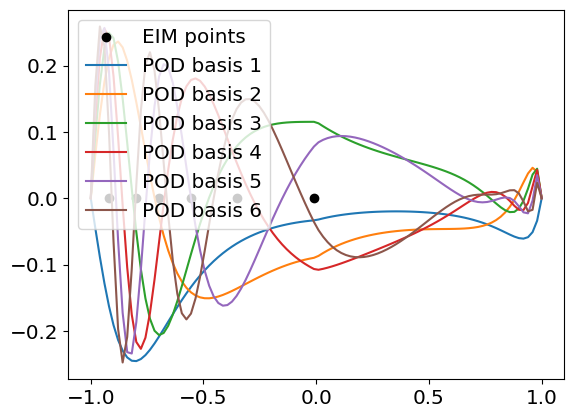

In [7]:
# Get DEIM indices
selected_indices = DEIM(u)

# plot POD basis vectors and first six spatial points
plt.scatter(x[selected_indices[:6]], np.zeros(6), c='black', label="EIM points")
for i in range(6):
    plt.plot(x, u[:, i], label=f"POD basis {i+1}")
plt.legend()
plt.show()

# look at DEIM approximations for these mu values and 10 DEIM modes
test_mu = [1.17, 1.5, 2.3, 3.1]
s_op = np.zeros((f.shape[0], 10)) # selection operator
for i, idx in enumerate(selected_indices[:10]):
    s_op[idx, i] = 1
DEIM_proj = u[:, :10] @ np.linalg.inv(s_op.T @ u[:, :10]) @ s_op.T # DEIM projection
for mu_val in test_mu:
    sol = solution_fn(x, np.array([mu_val]))
    exact = s(sol.reshape(-1, 1), x, mu_val)
    DEIM_approximation = DEIM_proj @ exact

# Compare Errors for DEIM and NEIM

In [8]:
MAX_MODES = 6
NUM_TRAIN_PARAMS = 51
NUM_SPATIAL_POINTS = 100
x = np.linspace(-1, 1, NUM_SPATIAL_POINTS).reshape(-1,1)
mu = np.linspace(1, np.pi, NUM_TRAIN_PARAMS).reshape(-1,1).T
sols = solution_fn(x, mu.reshape(-1))
f = np.array([s(sols[i].reshape(-1, 1), x, mu[0, i]).reshape(-1) for i in range(sols.shape[0])]).T # shape = (space, parameters)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)

RO_DIM = 20

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ s(sols[i].reshape(-1, 1), x, mu[0, j]).reshape(-1)).reshape(-1)

test_mu = np.sort(np.random.uniform(size=500)*(np.pi-1)+1).reshape(-1,1).T
test_sols = solution_fn(x, test_mu.reshape(-1))
f_test = np.array([s(test_sols[i].reshape(-1, 1), x, test_mu[0, i]).reshape(-1) for i in range(test_sols.shape[0])]).T
proj_f_test = np.array([s(V[:, :RO_DIM] @ V[:, :RO_DIM].T @ test_sols[i].reshape(-1, 1), x, test_mu[0, i]).reshape(-1) for i in range(test_sols.shape[0])]).T

DEIM_errors = []
Actual_NEIM_errors = []

for num_modes in range(MAX_MODES, MAX_MODES+1, 1):
    s_op = np.zeros((f.shape[0], num_modes)) # selection operator
    for i, idx in enumerate(DEIM(u)[:num_modes]):
        s_op[idx, i] = 1
    DEIM_proj = u[:, :num_modes] @ np.linalg.inv(s_op.T @ u[:, :num_modes]) @ s_op.T # DEIM projection
    NEIM_approximation, NEIM_selected_indices = NEIM(ro_sols, f_NEIM, mu.reshape(-1), V[:, :RO_DIM], max_modes=num_modes, train_loop_iterations=10000) 
    print(NEIM_selected_indices)
    
    exact = V[:, :RO_DIM].T @ proj_f_test
    DEIM_approximation = V[:, :RO_DIM].T @ DEIM_proj @ proj_f_test
    Actual_NEIM_approximation = np.array([NEIM_approximation(new_mu, (V[:, :RO_DIM].T @ test_sols[i].reshape(-1, 1)).reshape(-1), num_modes) for i, new_mu in enumerate(test_mu.reshape(-1))]).T
    
    avg_error = np.mean([np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])])
    DEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Actual_NEIM_errors.append(avg_error)

50 Max Error: 1.0470292798018812 Mean Error: 0.8908501006930561
0 0.3518597386023773
100 0.00188858705456442
200 0.000438024813983155
300 0.00010749837961882729
400 5.319297048616392e-05
500 4.028993313300862e-05
600 3.2125147381442216e-05
700 2.5668912116982667e-05
800 2.046466038023486e-05
900 1.6266275708428903e-05
1000 1.2916603674430514e-05
1100 1.0298944301415112e-05
1200 8.303824728752325e-06
1300 6.816910885258685e-06
1400 5.723662962813571e-06
1500 4.920228426933884e-06
1600 4.321712287662477e-06
1700 3.8644979225536325e-06
1800 3.5038592900773027e-06
1900 3.209614675603339e-06
2000 2.961860433539974e-06
2100 2.747614344160435e-06
2200 2.6146838249131544e-06
2300 2.4299982612391085e-06
2400 2.3005406182133473e-06
2500 2.1796661826115163e-06
2600 2.0664423905754103e-06
2700 1.9601522535795203e-06
2800 1.8602204371581164e-06
2900 1.76616482934544e-06
3000 1.7538829402973213e-06
3100 1.6239936687154794e-06
3200 1.5645431610463837e-06
3300 1.5069098455554069e-06
3400 1.45107347562

In [9]:
mu[0, 50], mu[0, 2], mu[0, 26], mu[0, 0], mu[0, 49], mu[0, 10]

(3.141592653589793,
 1.0856637061435916,
 2.1136281798666925,
 1.0,
 3.098760800517997,
 1.4283185307179587)

## POD-NN vs. NEIM for the Nonlinear Term

0 0.04568066107720965
1000 2.2217963730767207e-07
2000 1.308662366013295e-07
3000 9.557148908927006e-08
4000 6.758300712703978e-08
5000 4.600376187727186e-08
6000 3.232476276314838e-08
7000 2.4848285381434527e-08
8000 2.033818289027771e-08
9000 1.7611855618275916e-08
10000 1.575265651597196e-08
11000 1.4279040331338217e-08
12000 1.3063985380886072e-08
13000 1.2196483586447302e-08
14000 1.108315019737983e-08
15000 1.0322890167480242e-08
16000 9.625603386644878e-09
17000 8.999367781097876e-09
18000 8.456953116685683e-09
19000 7.981821825850234e-09
20000 7.561340925771887e-09
21000 7.1936158352672935e-09
22000 6.856362990844424e-09
23000 6.5674332477875286e-09
24000 6.30570599549814e-09
25000 6.074366379714039e-09
26000 5.863791299977003e-09
27000 5.6713660275567065e-09
28000 5.501318623925564e-09
29000 5.3428151491048864e-09
30000 5.1944070330551795e-09
31000 5.051341240416298e-09
32000 4.914094445902862e-09
33000 4.782815597601945e-09
34000 4.6569397029019636e-09
35000 4.536236335560851

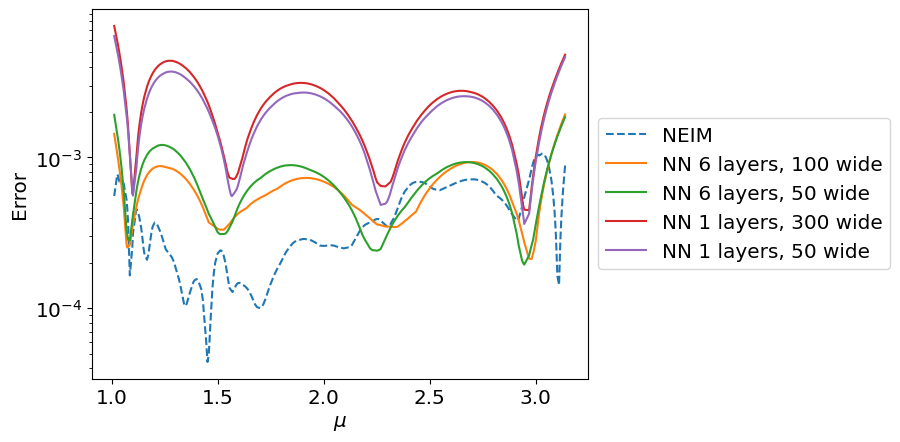

In [10]:
for hidden, width in [(6, 100), (6, 50), (1, 300), (1, 50)]:

    f_PODNN = np.array([f_NEIM[i, i, :] for i in range(f_NEIM.shape[0])])
    
    # train PODNN_Net with inputs mu and outputs f_PODNN
    PODNN_approximation = PODNN_Net(1, RO_DIM, width=width, num_hidden=hidden)
    
    optimizer = torch.optim.Adam(PODNN_approximation.parameters(), lr=0.001)    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)
    mse_loss = nn.MSELoss()
    
    x_data = torch.tensor(mu, dtype=torch.double).reshape(-1, 1)
    y_data = torch.tensor(f_PODNN)
    
    for epoch in range(50000):
        optimizer.zero_grad()
        output = PODNN_approximation(x_data)
        loss = mse_loss(output, y_data)
        if epoch % 1000 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
    
    PODNN_approximation.eval()

    NEIM_PODNN_errors_NEIM = []
    NEIM_PODNN_errors_PODNN = []
    for i, new_mu in enumerate(test_mu.reshape(-1)):
        new_mu = new_mu.reshape(1, -1)
        NEIM_result = NEIM_approximation(new_mu, (V[:, :RO_DIM].T @ test_sols[i].reshape(-1, 1)).reshape(-1), MAX_MODES)
        PODNN_result = PODNN_approximation(torch.tensor(new_mu.reshape(-1), dtype=torch.double)).detach().numpy()
        actual_result = (V[:, :RO_DIM].T @ f_test)[:, i]
    
        NEIM_error = np.sum(np.abs(NEIM_result - actual_result))
        PODNN_error = np.sum(np.abs(PODNN_result - actual_result))
    
        NEIM_PODNN_errors_NEIM.append(NEIM_error)
        NEIM_PODNN_errors_PODNN.append(PODNN_error)

    if hidden == 6 and width == 100:
        plt.plot(test_mu.reshape(-1), NEIM_PODNN_errors_NEIM, label="NEIM", linestyle='--')
    plt.plot(test_mu.reshape(-1), NEIM_PODNN_errors_PODNN, label=f"NN {hidden} layers, {width} wide")
    plt.xlabel("$\\mu$")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
    #plt.show()
plt.savefig('./Paper Figures/NEIM_PODNN_Comparison.pdf', bbox_inches='tight', dpi=500)
plt.show()

## Exact Nonlinearity and NEIM/DEIM Error

In [11]:
deim_selected_indices = [int(np.sum(s_op[:, i] * np.arange(s_op.shape[0])) + 0.5) for i in range(s_op.shape[1])]

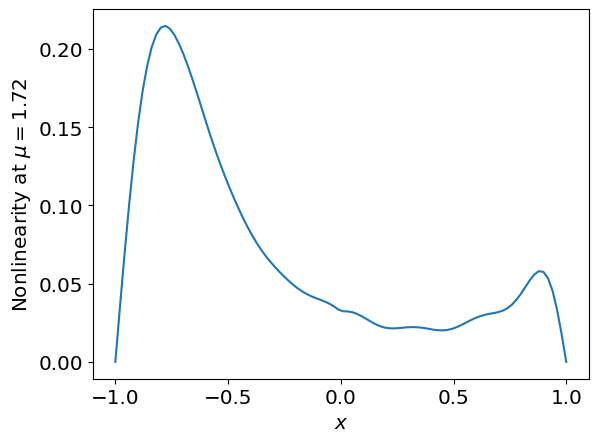

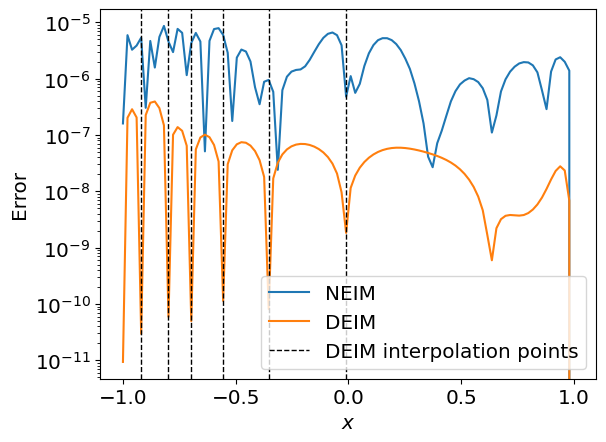

In [12]:
plt.plot(x, V[:,:RO_DIM] @ exact[:, 175])
plt.xlabel("$x$")
plt.ylabel(f"Nonlinearity at $\\mu = {test_mu[0, 175]:.2f}$")
plt.savefig('./Paper Figures/exact_nonlinearity.pdf', bbox_inches='tight', dpi=500)
plt.show()

plt.plot(x, np.abs(V[:,:RO_DIM] @ exact[:, 175] - V[:,:RO_DIM] @ Actual_NEIM_approximation[:, 175]), label="NEIM")
plt.plot(x, np.abs(V[:,:RO_DIM] @ exact[:, 175] - V[:,:RO_DIM] @ DEIM_approximation[:, 175]), label="DEIM")
for sidx in deim_selected_indices:
    if sidx == deim_selected_indices[0]:
        plt.axvline(x=x[sidx, 0], color='black', linestyle='--', linewidth=1.0, label='DEIM interpolation points')
    else:
        plt.axvline(x=x[sidx, 0], color='black', linestyle='--', linewidth=1.0)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("Error")
plt.yscale('log')
plt.savefig('./Paper Figures/exact_nonlinearity_error.pdf', bbox_inches='tight', dpi=500)
plt.show()

## NEIM/DEIM Modes at Selected NEIM Parameter

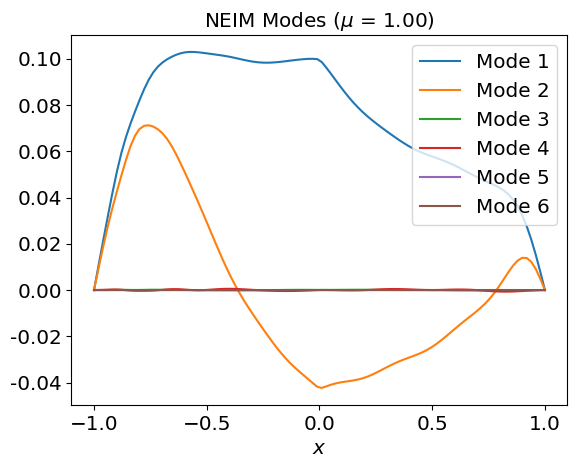

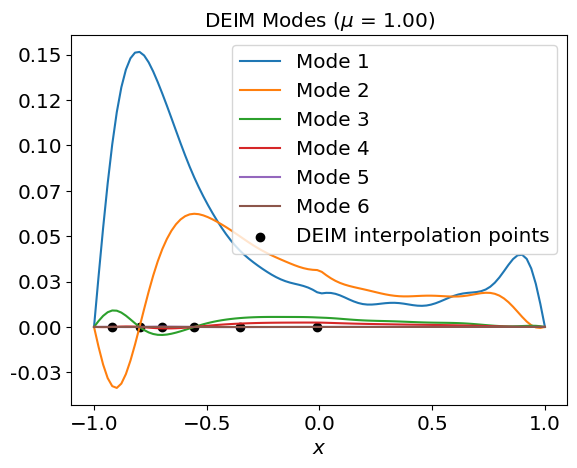

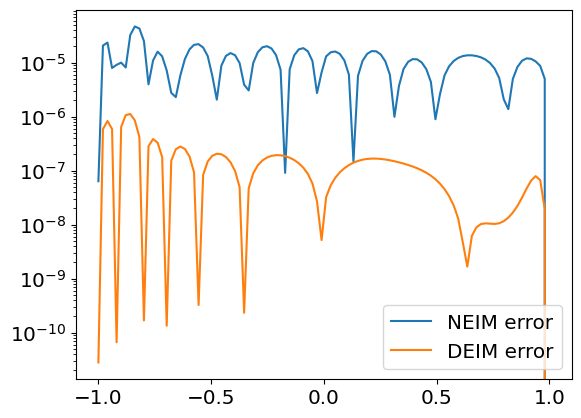

In [13]:
pidx = 0
mode1 = V[:,:RO_DIM] @ NEIM_approximation(mu[0, pidx], (V[:, :RO_DIM].T @ sols[pidx].reshape(-1, 1)).reshape(-1), 1)
mode2 = V[:,:RO_DIM] @ NEIM_approximation(mu[0, pidx], (V[:, :RO_DIM].T @ sols[pidx].reshape(-1, 1)).reshape(-1), 2) - mode1
mode3 = V[:,:RO_DIM] @ NEIM_approximation(mu[0, pidx], (V[:, :RO_DIM].T @ sols[pidx].reshape(-1, 1)).reshape(-1), 3) - mode2 - mode1
mode4 = V[:,:RO_DIM] @ NEIM_approximation(mu[0, pidx], (V[:, :RO_DIM].T @ sols[pidx].reshape(-1, 1)).reshape(-1), 4) - mode3 - mode2 - mode1
mode5 = V[:,:RO_DIM] @ NEIM_approximation(mu[0, pidx], (V[:, :RO_DIM].T @ sols[pidx].reshape(-1, 1)).reshape(-1), 5) - mode4 - mode3 - mode2 - mode1
mode6 = V[:,:RO_DIM] @ NEIM_approximation(mu[0, pidx], (V[:, :RO_DIM].T @ sols[pidx].reshape(-1, 1)).reshape(-1), 6) - mode5 - mode4 - mode3 - mode2 - mode1

plt.plot(x, mode1, label='Mode 1')
plt.plot(x, mode2, label='Mode 2')
plt.plot(x, mode3, label='Mode 3')
plt.plot(x, mode4, label='Mode 4')
plt.plot(x, mode5, label='Mode 5')
plt.plot(x, mode6, label='Mode 6')
plt.xlabel("$x$")
plt.title(f"NEIM Modes ($\\mu$ = {mu[0, pidx]:.2f})")
plt.legend()
formatter = mticker.FormatStrFormatter('%.2f')
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig('./Paper Figures/neim_modes_selected_parameter.pdf', bbox_inches='tight', dpi=500)
plt.show()

cumulative_modes = 0
DEIM_modes = {}
for num_modes in range(1, 7):
    s_op = np.zeros((f.shape[0], num_modes)) # selection operator
    for i, idx in enumerate(DEIM(u)[:num_modes]):
        s_op[idx, i] = 1
    DEIM_proj = u[:, :num_modes] @ np.linalg.inv(s_op.T @ u[:, :num_modes]) @ s_op.T # DEIM projection    
    DEIM_mode = V[:,:RO_DIM] @ V[:, :RO_DIM].T @ DEIM_proj @ f[:, pidx]
    
    plt.plot(x, DEIM_mode - cumulative_modes, label=f'Mode {num_modes}')
    cumulative_modes = DEIM_mode
    DEIM_modes[f'mode{num_modes}'] = DEIM_mode - cumulative_modes

exact = V[:, :RO_DIM] @ V[:, :RO_DIM].T @ f[:, pidx]

plt.xlabel("$x$")
plt.title(f"DEIM Modes ($\\mu$ = {mu[0, pidx]:.2f})")
for sidx in deim_selected_indices:
    if sidx == deim_selected_indices[0]:
        plt.scatter(x[sidx, 0], 0, color='black', label='DEIM interpolation points')
    else:
        plt.scatter(x[sidx, 0], 0, color='black')
plt.legend()
formatter = mticker.FormatStrFormatter('%.2f')
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig('./Paper Figures/deim_modes_selected_parameter.pdf', bbox_inches='tight', dpi=500)
plt.show()

plt.semilogy(x, np.abs(mode1 + mode2 + mode3 + mode4 + mode5 + mode6 - exact), label="NEIM error")
plt.semilogy(x, np.abs(cumulative_modes - exact), label="DEIM error")
plt.legend()
plt.savefig('./Paper Figures/neim_deim_error_selected_parameter.pdf', bbox_inches='tight', dpi=500)
plt.show()

## NEIM/DEIM Modes at New Parameter

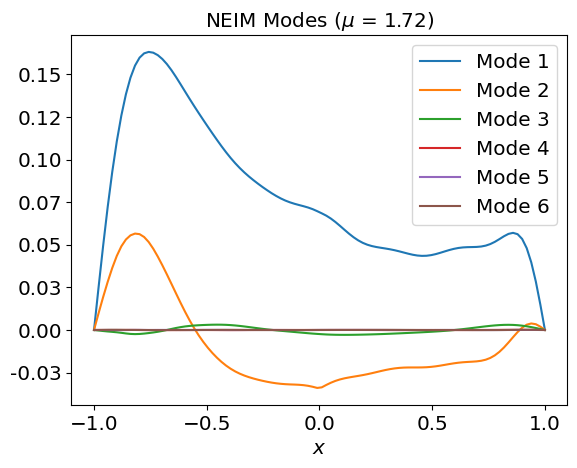

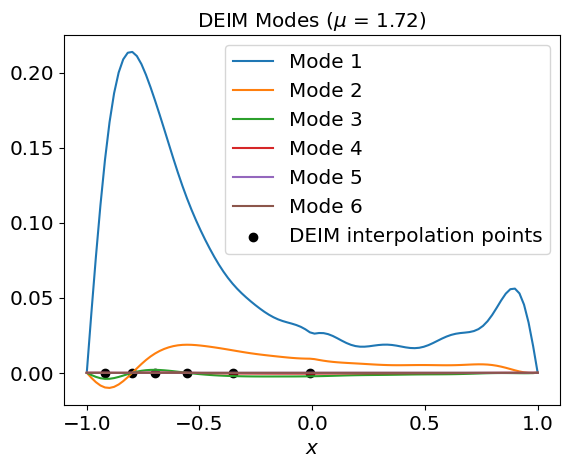

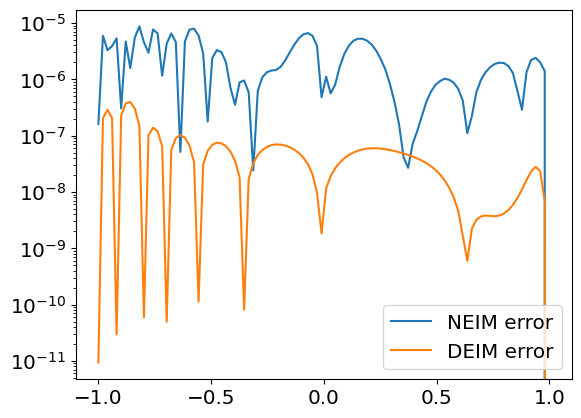

In [14]:
for pidx in [175]:
    mode1 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 1)
    mode2 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 2) - mode1
    mode3 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 3) - mode2 - mode1
    mode4 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 4) - mode3 - mode2 - mode1
    mode5 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 5) - mode4 - mode3 - mode2 - mode1
    mode6 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 6) - mode5 - mode4 - mode3 - mode2 - mode1
    
    plt.plot(x, mode1, label='Mode 1')
    plt.plot(x, mode2, label='Mode 2')
    plt.plot(x, mode3, label='Mode 3')
    plt.plot(x, mode4, label='Mode 4')
    plt.plot(x, mode5, label='Mode 5')
    plt.plot(x, mode6, label='Mode 6')
    plt.xlabel("$x$")
    plt.title(f"NEIM Modes ($\\mu$ = {test_mu[0, pidx]:.2f})")
    plt.legend()
    formatter = mticker.FormatStrFormatter('%.2f')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.savefig('./Paper Figures/neim_modes_new_parameter.pdf', bbox_inches='tight', dpi=500)
    plt.show()
    
    cumulative_modes = 0
    DEIM_modes = {}
    for num_modes in range(1, 7):
        s_op = np.zeros((f.shape[0], num_modes)) # selection operator
        for i, idx in enumerate(DEIM(u)[:num_modes]):
            s_op[idx, i] = 1
        DEIM_proj = u[:, :num_modes] @ np.linalg.inv(s_op.T @ u[:, :num_modes]) @ s_op.T # DEIM projection    
        DEIM_mode = V[:,:RO_DIM] @ V[:, :RO_DIM].T @ DEIM_proj @ proj_f_test[:, pidx]
        
        plt.plot(x, DEIM_mode - cumulative_modes, label=f'Mode {num_modes}')
        cumulative_modes = DEIM_mode
        DEIM_modes[f'mode{num_modes}'] = DEIM_mode - cumulative_modes

    exact = V[:, :RO_DIM] @ V[:, :RO_DIM].T @ proj_f_test[:, pidx]
    
    plt.xlabel("$x$")
    plt.title(f"DEIM Modes ($\\mu$ = {test_mu[0, pidx]:.2f})")
    for sidx in deim_selected_indices:
        if sidx == deim_selected_indices[0]:
            plt.scatter(x[sidx, 0], 0, color='black', label='DEIM interpolation points')
        else:
            plt.scatter(x[sidx, 0], 0, color='black')
    plt.legend()
    formatter = mticker.FormatStrFormatter('%.2f')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.savefig('./Paper Figures/deim_modes_new_parameter.pdf', bbox_inches='tight', dpi=500)
    plt.show()
    
    plt.semilogy(x, np.abs(mode1 + mode2 + mode3 + mode4 + mode5 + mode6 - exact), label="NEIM error")
    plt.semilogy(x, np.abs(cumulative_modes - exact), label="DEIM error")
    plt.legend()
    plt.savefig('./Paper Figures/neim_deim_error_new_parameter.pdf', bbox_inches='tight', dpi=500)
    plt.show()

## Make GIF

In [ ]:
for pidx in range(500):
    mode1 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 1)
    mode2 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 2) - mode1
    mode3 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 3) - mode2 - mode1
    mode4 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 4) - mode3 - mode2 - mode1
    mode5 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 5) - mode4 - mode3 - mode2 - mode1
    mode6 = V[:,:RO_DIM] @ NEIM_approximation(test_mu[0, pidx], (V[:, :RO_DIM].T @ test_sols[pidx].reshape(-1, 1)).reshape(-1), 6) - mode5 - mode4 - mode3 - mode2 - mode1
    
    plt.plot(x, mode1, label='Mode 1')
    plt.plot(x, mode2, label='Mode 2')
    plt.plot(x, mode3, label='Mode 3')
    plt.plot(x, mode4, label='Mode 4')
    plt.plot(x, mode5, label='Mode 5')
    plt.plot(x, mode6, label='Mode 6')
    plt.xlabel("$x$")
    plt.title(f"NEIM Modes ($\\mu$ = {test_mu[0, pidx]:.2f})")
    plt.legend(loc='upper right')
    plt.ylim(-0.05, 0.32)
    plt.xlim(-1.1, 1.1)
    plt.savefig(f"./GIF_Images/{pidx}.png", bbox_inches='tight', dpi=500)
    plt.show()